## Problem Statement

In this exercise https://www.kaggle.com/c/ga-customer-revenue-prediction , the aim is to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict purchase likelihood of the customer. The exercise here is an exposition of the data and look into the Google Analytics (GA) data about the personas of the visitors and the analysis might lead to a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

Both data files "learn.csv" and "verify.csv" are converted from the JSON format data usually collected over webs, mobile applications and IoT log files which can easily be imported into a python data framework for analysis. It is also essential to apply data processing steps to clear the data file for the analysis.

## Objectives:

- Help to extract the most important factor determining the above business objective.
- Dig out any relevant insights for the questions.


## Questions

**Q1:** Separate visitors who stay to purchase, who do not. (Make my own definition on potential purchaser)


**Q2:** Seek out insights of the personas of the visitors who are potential purchasers (defined in Q1)


**Q3:** Using 3 different kinds of algorithms or methods to determine the most importance factors to predict the potential purchaser  by divided the file "learn.csv" into train file and test file, please brief describe each algorithm


**Q4.** Based on the findings, suggest attracting more potential purchasers to the GStore based on decision model taught in the course 




In [3]:
# load the required packages

import datetime as dt
import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)

# packages for meachine learning models
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier  
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from math import sqrt
from sklearn.metrics import mean_squared_error

In [4]:
# read in data
train = pd.read_csv("learn.csv")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 57 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   channelGrouping                                    20000 non-null  object 
 1   date                                               20000 non-null  int64  
 2   fullVisitorId                                      20000 non-null  uint64 
 3   socialEngagementType                               20000 non-null  object 
 4   visitId                                            20000 non-null  int64  
 5   visitNumber                                        20000 non-null  int64  
 6   visitStartTime                                     20000 non-null  int64  
 7   device.browser                                     20000 non-null  object 
 8   device.browserVersion                              20000 non-null  object 
 9   device

### Missing Values Percentage

From the above snapshot we can observe that there are many missing values in the dataset. 

There are 14 columns with missing values


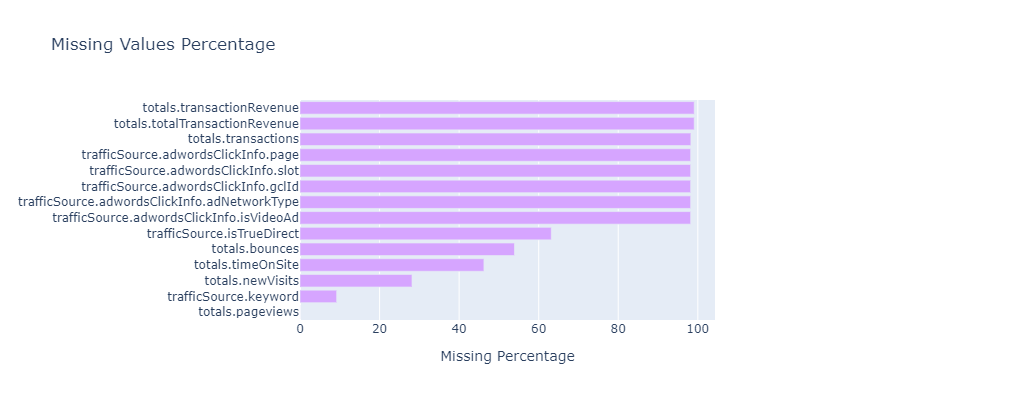

In [6]:
miss_per = {}
for k, v in dict(train.isna().sum(axis=0)).items():
    if v == 0:
        continue
    miss_per[k] = 100 * float(v) / len(train)
    
import operator 
sorted_x = sorted(miss_per.items(), key=operator.itemgetter(1), reverse=True)
print ("There are " + str(len(miss_per)) + " columns with missing values")

kys = [_[0] for _ in sorted_x][::-1]
vls = [_[1] for _ in sorted_x][::-1]
trace1 = go.Bar(y = kys, orientation="h" , x = vls, marker=dict(color="#d6a5ff"))
layout = go.Layout(title="Missing Values Percentage", 
                   xaxis=dict(title="Missing Percentage"), 
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

In [7]:
train = train.drop(['trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 
                    'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd'], axis = 1)

##### Not necesssary to keep two Visitor IDs, we drop one of them and relevant Transaction Revenue variable.

In [8]:
train = train.drop(["totals.transactionRevenue", "visitId"], axis = 1)

## Questions

### Q1: Separate visitors who stay to purchase, who do not. (Make my own definition on potential purchaser here.)


### Answer:

The definition on potential purchaser for this dataset as:
- We treat the potential purchaser based on the column - "totals.transactions", which is defined as Total number of ecommerce transactions within the session by GStore). Those visitors with record on "totals.transactions" could be quick decision makers or they may have a strong demand to buy their target goods/services before visiting the GStore. Also, they could be the emotional buyers to make purchase easily because of the attractive marketing package. 
- We treat the duplicated records in column of "fullVisitorId" in this dataset as repeated purchasers. Because the potential purchasers may be not share the similar intention in buying things, we should not just count the unique records based on "fullVisitorId".



### Q2: Seek out insights of the personas of the visitors who are potential purchasers (defined in Q1)


### Answer: 

From this dataset, I have done some desciptive analysis on three aspects on those visitors with transaction records in GStore, including devices attributes, GeoNetwork attributes and traffic attributes. 
- Regarding the devices attributes, it means that what electronic devices and OS platform the potential purchasers will use to approach GStore. From the findings, most of the potential purchasers will visit through the desktop, via Chrome by using Macbook or Windows OS platform. It mataches our common knownledge as Macintosh and Windows are the biggest OS desktop OS providers in the world. However, by looking at those willing going to finish the transactions with GStore, most of them will use Internet Explorer instead of Chrome. Interesting, as now more and more people prefers to do transactions on their mobiles, the data shows that it is still a significant number of people would do this by desktop instead.   
- For the analysis on geo-location factors, most of the visitors are from the America, then Europe and Asia. However, GStore captures most of its revenue from Asia region, then Oceania and America. It is worth to explore further about the buying bahviour between Asian and American people. It seems Western people quite like to do a frequent "online window-shopping", rather than Asia, but more Asian would accept online purchasing and ordering.
- Regarding the traffic attributes, as we have a quite imbalance dataset between Purchased & Not-Yet-Purcahse, we have a quite balanced distribution in terms of the campaign channels drawings the sales among the campaigns held through shared promotion, Google brand, bags and Appeal. It is worth to do a further study about what "other" factors likely to be by drawing most of the traffic to GStore.

In [9]:
# Distribution of between of number of Stay to purchase and Not to purchase

train["totals.transactions"] = train["totals.transactions"].fillna(0)

train["totals.transactions"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
19995    0.0
19996    0.0
19997    0.0
19998    0.0
19999    1.0
Name: totals.transactions, Length: 20000, dtype: float64

#### Not necesssary to keep two Visitor IDs, we drop one of them and relevant Transaction Revenue variable.

In [10]:
#train = train.drop(['trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 
#                    'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType',
#       'trafficSource.adwordsClickInfo.isVideoAd'], axis = 1)

In [11]:
tranc = train[train["totals.transactions"] > 0]
tranc.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,...,totals.totalTransactionRevenue,totals.bounces,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters
268,Direct,20180511,567632072087918290,Not Socially Engaged,1,1526043913,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,...,24990000.0,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset
353,Organic Search,20180511,34941760139500427,Not Socially Engaged,1,1526090105,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,...,151990000.0,NaN,(not set),(not set),google,organic,(not provided),(not set),NaN,not available in demo dataset
369,Direct,20180511,7417113168654151999,Not Socially Engaged,1,1526052977,Chrome,not available in demo dataset,not available in demo dataset,Windows,...,9730000.0,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset
381,Referral,20180511,5963345090934142475,Not Socially Engaged,3,1526051906,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,...,84620000.0,NaN,/,(not set),(direct),(none),NaN,(not set),True,not available in demo dataset
391,Organic Search,20180511,6525673967695077450,Not Socially Engaged,1,1526098702,Chrome,not available in demo dataset,not available in demo dataset,Android,...,45980000.0,NaN,(not set),(not set),google,organic,(not provided),(not set),NaN,not available in demo dataset


In [12]:
# replace purchase in "2" to "1" to indicate binary value in "1"
train['Potential_Purchase'] = train["totals.transactions"].replace(2, 1)


In [13]:
# test the shape
train["totals.transactions"].shape

(20000,)

In [14]:
# test the unique value
train['Potential_Purchase'].unique()

array([0., 1.])

### Distribution of Visitors - Purchase / Not to Purchase

- 0 - Not to Purchase
- 1 - Purchase

<AxesSubplot:ylabel='Potential_Purchase'>

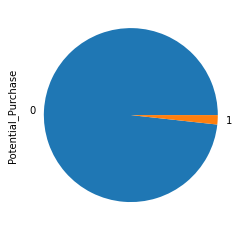

In [15]:
train["Potential_Purchase"].astype('int').value_counts().plot(kind='pie', labels=['0', '1'], figsize=(4,4))

### Device Attributes

> - There is a significant difference in visits from mobile and tablets, but mean revenue for both of them is very close.  
> - Interesting to note that maximum visits are from Chrome browser however maximum revenue is collected from visits throught firefox. 
> - Chrome OS users has generated maximum revenue though maximum visits are from windows and macintosh users  


C:\Users\Fenix\anaconda3\envs\econ7970\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



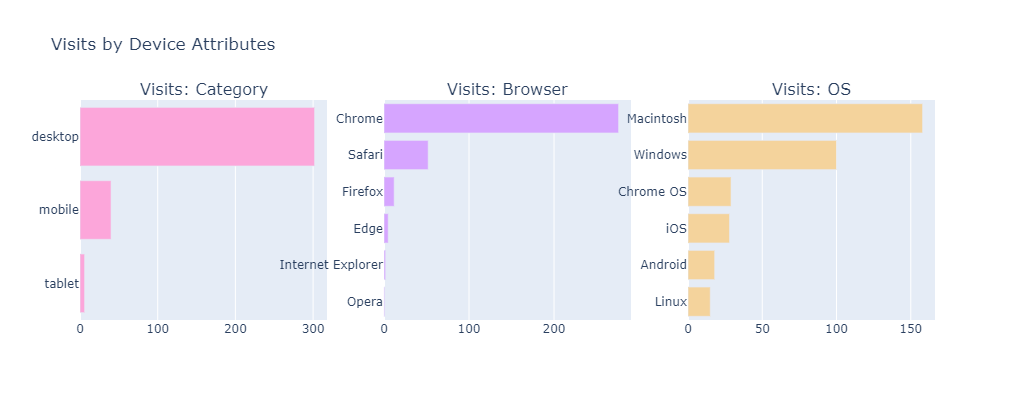

<ipython-input-16-b33c67b9017a>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



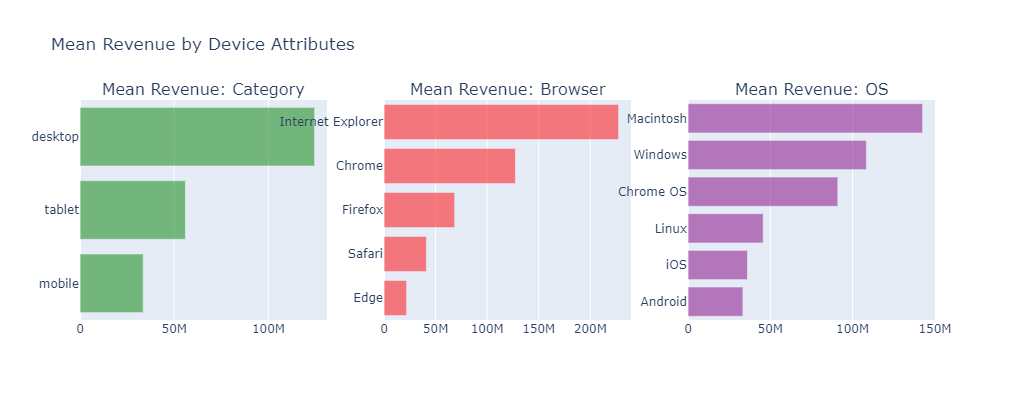

In [16]:
device_cols = ["device.browser", "device.deviceCategory", "device.operatingSystem"]

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(device_cols):
    t = tranc[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15][::-1], x = t.values[:15][::-1]))

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits: Category", "Visits: Browser","Visits: OS"], print_grid=False)
fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[0], 1, 2)
fig.append_trace(traces[2], 1, 3)

fig['layout'].update(height=400, showlegend=False, title="Visits by Device Attributes")
iplot(fig)

## convert transaction revenue to float
tranc["totals.totalTransactionRevenue"] = tranc["totals.totalTransactionRevenue"].astype('float')

device_cols = ["device.browser", "device.deviceCategory", "device.operatingSystem"]

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Mean Revenue: Category", "Mean Revenue: Browser","Mean Revenue: OS"], print_grid=False)

colors = ["red", "green", "purple"]
trs = []
for i, col in enumerate(device_cols):
    tmp = tranc.groupby(col).agg({"totals.totalTransactionRevenue": "mean"}).reset_index().rename(columns={"totals.totalTransactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(x = tmp["Mean Revenue"][::-1], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col][::-1])
    trs.append(tr)

fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[0], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False, title="Mean Revenue by Device Attributes")
iplot(fig)

### GeoNetwork Attributes 

C:\Users\Fenix\anaconda3\envs\econ7970\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



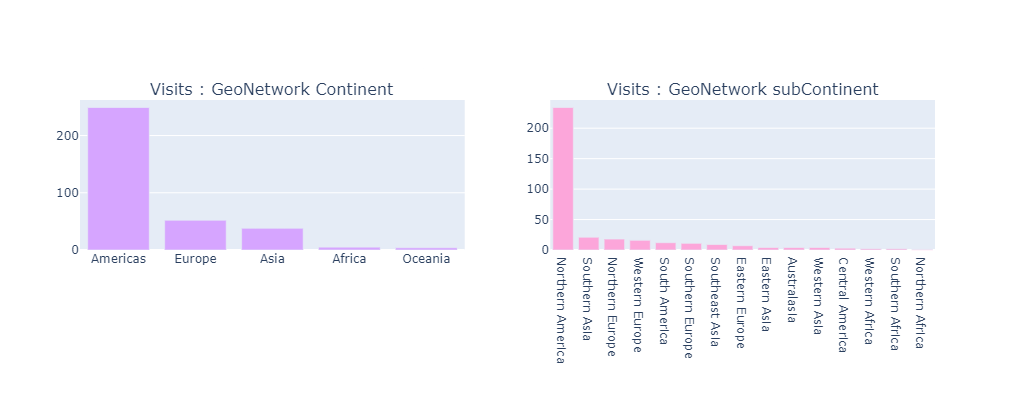

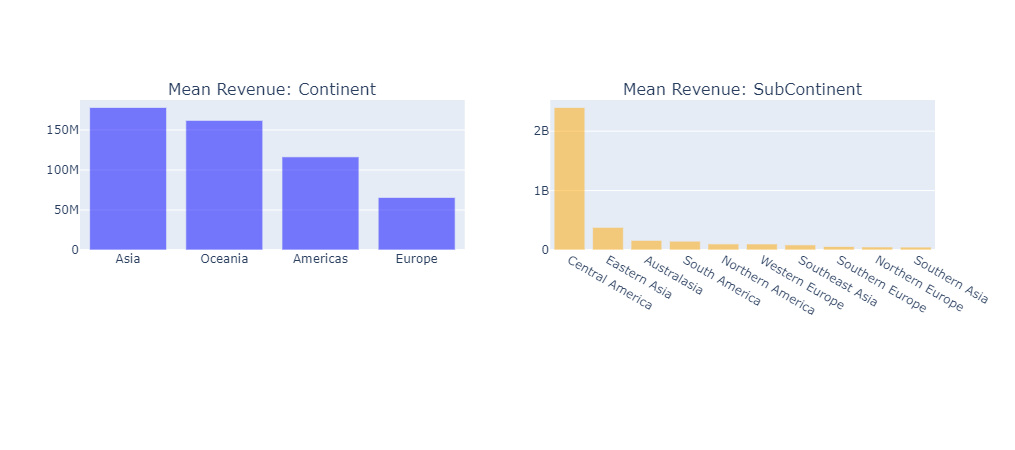

In [17]:
geo_cols = ['geoNetwork.city', 'geoNetwork.continent','geoNetwork.country',
            'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']
geo_cols = ['geoNetwork.continent','geoNetwork.subContinent']

colors = ["#d6a5ff", "#fca6da"]
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Visits : GeoNetwork Continent", "Visits : GeoNetwork subContinent"], print_grid=False)
trs = []
for i,col in enumerate(geo_cols):
    t = tranc[col].value_counts()
    tr = go.Bar(x = t.index[:20], marker=dict(color=colors[i]), y = t.values[:20])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=400, margin=dict(b=150), showlegend=False)
iplot(fig)




geo_cols = ['geoNetwork.continent','geoNetwork.subContinent']
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Mean Revenue: Continent", "Mean Revenue: SubContinent"], print_grid=False)

colors = ["blue", "orange"]
trs = []
for i, col in enumerate(geo_cols):
    tmp = tranc.groupby(col).agg({"totals.totalTransactionRevenue": "mean"}).reset_index().rename(columns={"totals.totalTransactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(y = tmp["Mean Revenue"], orientation="v", marker=dict(opacity=0.5, color=colors[i]), x= tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=450, margin=dict(b=200), showlegend=False)
iplot(fig)

### Traffic Attributes

C:\Users\Fenix\anaconda3\envs\econ7970\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



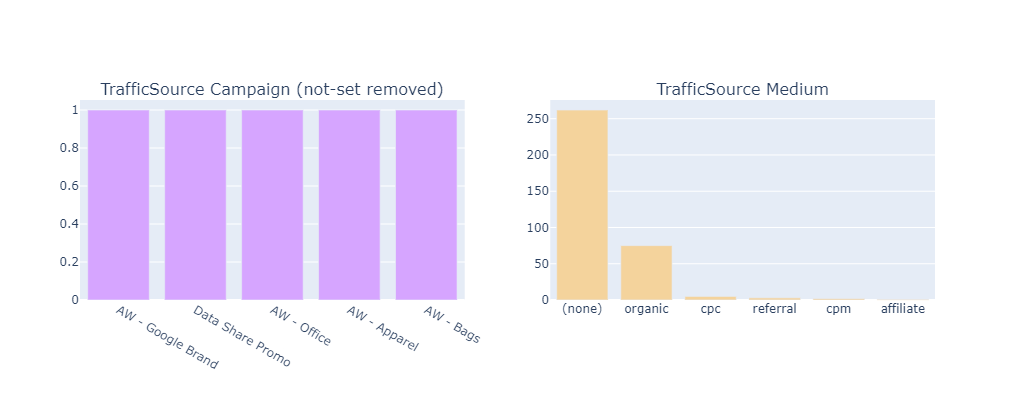

In [18]:
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["TrafficSource Campaign (not-set removed)", "TrafficSource Medium"], print_grid=False)

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
t1 = tranc["trafficSource.campaign"].value_counts()
t2 = tranc["trafficSource.medium"].value_counts()
tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[3]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))
tr3 = go.Bar(x = t1.index[1:], y = t1.values[1:], marker=dict(color=colors[0]))
tr4 = go.Bar(x = t2.index[1:], y = t2.values[1:])

fig.append_trace(tr3, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=400, margin=dict(b=100), showlegend=False)
iplot(fig)

## Data for Modelling

### Q3: Using 3 different kinds of algorithms or methods to determine the most importance factors to predict the potential purchaser  by divided the file "learn.csv" into train file and test file, please brief describe each algorithm


### Answer:


- The total mark of the project is 30% of the course grade. Evaluation based on your efficient code, your description on how to approach the problem and the explanation about steps taken to address the issue.
- For the hyperparameters' setup for training the models' performance, I put 75% as training data and 25% as testing data, by pinning down the 70% as threshold.
- For this dataset, I have tried to run 8 prediction models below and do a cross evalaution between the models for comaprison. 
    - LogisticRegression
    - DecisionTreeClassifier
    - RandomForestClassifier
    - AdaBoostClassifier
    - GradientBoostingClassifier
    - LGBMClassifier
    - XGBClassifier
    - CatBoostClassifier
- Since this dataset has a problem of imbalance dataset, the "0" (not to buy) overwhelm the "1" (purchase) records. The Accuracy rate cannot be used as a benchmark to judge the model's performance as it will include the accuracy rate for predicting True Negative. Instead, I use the F-1 score to jusfify the models' performance as F1-score can help balance the metric across positive/negative samples.
- Throughout the models' performance, F-1 score almost got 99%, it may not be fully reflecting the model performance. Except the imbalanced dataset, I use the "totals.transactions" to create a dummy depending variable for training models. As the "totals.transactions" is almost a binary variable with value of between [0,1]. It may not be a good approach as it may miss out the prediction on "how likely" or "how willing to happen" in degrees, like other numerical variable.
- At the end, I choose the Logistic Regression, Random Forest and Decision Tree models which are typical models for binary decision. It also have advanatage to have further investigation on which factor/attributes influencing the purchasing decision most within the algorithm, unlike other fast-processing prediction with "blackbox" in their algorithms.
- Below are the brief intriduction about these three models for reference.

**Logistic Regression**
Logisitic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

**Decision Tree Classifier**
DecisionTreeClassifier is a class capable of performing multi-class classification on a dataset.

As with other classifiers, DecisionTreeClassifier takes as input two arrays: an array X, sparse or dense, of size [n_samples, n_features] holding the training samples, and an array Y of integer values, size [n_samples], holding the class labels for the training samples:

**Random Forest Classifier**
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

**(Please find detailed analysis and coding below)**


### Modelling Preprocessing Reminder

Remember many algorithms only work in numeric and can not run with missing variable, these are two essential step to check on types of variables and eliminate missing variables

There are several important steps to deal with data variables

1. Drop single value variables 

2. Deal with missing variables again

3. Drop too many type categorical/object variables

4. Trace out another labels of configuration of nill inputs

5. Create variables from "date" and "time" variables

6. Encode the categorical variables

In [19]:
train.shape

(20000, 51)

### Drop single value varaibles

Takeoff all columns where we have a unique value (constants). It is useful because this columns don't give us any information

In [20]:
discovering_consts = [col for col in train.columns if train[col].nunique() == 1]
# printing the total of columns dropped and the name of columns 
print("Columns with just one value: ", len(discovering_consts), "columns")
print("Name of constant columns: \n", discovering_consts)
train = train.drop(discovering_consts, axis=1)

Columns with just one value:  22 columns
Name of constant columns: 
 ['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.newVisits', 'totals.bounces', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.criteriaParameters']


In [21]:
train.shape

(20000, 29)

### Missing Variables

Below is the code chunk found in https://www.kaggle.com/gpreda to deal with "missing variables"

In [22]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent

    print("Total columns at least one missing Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    #print("\n Total of Sales % of Total: ", round((train[train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(df_train['totals.transactionRevenue']) * 100),4))
    return 
missing_values(train)

Total columns at least one missing Values: 
                                Total  Percent
totals.totalTransactionRevenue  19821   99.105
totals.timeOnSite                9247   46.235
trafficSource.keyword            1845    9.225
totals.pageviews                    4    0.020


### Drop too many type categorical variables

One may like to focus on small number of types of categorial (or object) variables, so you may like to drop
unique value of variables with dimensions more than either 20 or ... or 50


In [23]:
columns = list(train.select_dtypes(include='object')) # category or object
# for col in columns:
#    train[col].nunique()


for col in columns:
        if train[col].nunique() > 20: # number to be determined
             train = train.drop(col, axis=1)

In [24]:
train.shape

(20000, 20)

### Trace out another labels of configuration of nill inputs
Setting nill fill variables, closed to the meaning to missing variable)

In [25]:
columns = list(train.select_dtypes(include='object'))
for col in columns:
    print(f"Varaibles name = ", col)
    print(f"Unique Value = ", train[col].unique()) 
    print(f" ")

Varaibles name =  channelGrouping
Unique Value =  ['Organic Search' 'Direct' 'Affiliates' 'Referral' 'Paid Search' 'Social'
 'Display' '(Other)']
 
Varaibles name =  device.browser
Unique Value =  ['Chrome' 'Internet Explorer' 'Safari (in-app)' 'Edge' 'Safari' 'Firefox'
 'YaBrowser' 'Opera' 'Android Webview' 'Opera Mini' 'UC Browser'
 'Samsung Internet' 'Amazon Silk' 'Mozilla Compatible Agent' 'Coc Coc'
 'Maxthon' 'Android Browser' 'Puffin']
 
Varaibles name =  device.operatingSystem
Unique Value =  ['Android' 'Macintosh' 'Chrome OS' 'iOS' 'Windows' 'Linux' 'Windows Phone'
 'Samsung' 'Tizen' 'BlackBerry' '(not set)' 'OS/2' 'Xbox']
 
Varaibles name =  device.deviceCategory
Unique Value =  ['mobile' 'desktop' 'tablet']
 
Varaibles name =  geoNetwork.continent
Unique Value =  ['Asia' 'Americas' 'Europe' 'Oceania' '(not set)' 'Africa']
 
Varaibles name =  trafficSource.campaign
Unique Value =  ['(not set)' 'Data Share Promo' 'Run of Network Line Item'
 'Page: contains "/google+redesign/dri

Trace out special characters that may affect running the code, repeat the above step and below step until it is done.

In [26]:
for col in columns:
        train[col] = train[col].str.replace("(", "")
        train[col] = train[col].str.replace(")", "")
        train[col].astype('object')

### Drop mix type varaible if exists

In [27]:
#train = train.drop(" ", axis=1) # "trafficSource.keyword" 
train.shape


(20000, 20)

### Check again for any NA value

In [28]:
train.isna().sum()

channelGrouping                       0
date                                  0
fullVisitorId                         0
visitNumber                           0
visitStartTime                        0
device.browser                        0
device.operatingSystem                0
device.isMobile                       0
device.deviceCategory                 0
geoNetwork.continent                  0
totals.hits                           0
totals.pageviews                      4
totals.timeOnSite                  9247
totals.sessionQualityDim              0
totals.transactions                   0
totals.totalTransactionRevenue    19821
trafficSource.campaign                0
trafficSource.medium                  0
trafficSource.adContent               0
Potential_Purchase                    0
dtype: int64

In [29]:
# drop clumn with too many null values still
train.drop(['totals.timeOnSite', 'totals.totalTransactionRevenue'], axis=1, inplace=True)

In [30]:
train['totals.pageviews'].fillna(0, inplace=True)

In [31]:
train.isna().sum()

channelGrouping             0
date                        0
fullVisitorId               0
visitNumber                 0
visitStartTime              0
device.browser              0
device.operatingSystem      0
device.isMobile             0
device.deviceCategory       0
geoNetwork.continent        0
totals.hits                 0
totals.pageviews            0
totals.sessionQualityDim    0
totals.transactions         0
trafficSource.campaign      0
trafficSource.medium        0
trafficSource.adContent     0
Potential_Purchase          0
dtype: int64

### Create variables from "date" and "time" variables

In [32]:
train['formated_date'] = pd.to_datetime(train['date'], format='%Y%m%d', errors='coerce')
train['year'] = train['formated_date'].apply(lambda x:x.year)
train['month'] = train['formated_date'].apply(lambda x:x.month)
#train['montht'] = train['formated_date'].apply(lambda x:x.day/10)
train['weekday'] = train['formated_date'].apply(lambda x:x.weekday())

In [33]:
train['formated_time'] = pd.to_datetime(train['visitStartTime'], unit='s', errors='coerce')
train['time']=pd.to_datetime(train['formated_time'], format='%d-%m-%Y %H:%M:%S.%f', errors='coerce')
train['hr'] = train['formated_time'].apply(lambda x:x.hour)

In [34]:
train.drop(['date','time','formated_date','formated_time'], axis=1, inplace=True)
train.astype({'year': 'object','month': 'object','hr':'object','weekday':'object'}).dtypes

channelGrouping              object
fullVisitorId                uint64
visitNumber                   int64
visitStartTime                int64
device.browser               object
device.operatingSystem       object
device.isMobile                bool
device.deviceCategory        object
geoNetwork.continent         object
totals.hits                   int64
totals.pageviews            float64
totals.sessionQualityDim      int64
totals.transactions         float64
trafficSource.campaign       object
trafficSource.medium         object
trafficSource.adContent      object
Potential_Purchase          float64
year                         object
month                        object
weekday                      object
hr                           object
dtype: object

In [35]:
train.shape

(20000, 21)

In [36]:
train['Potential_Purchase'].shape

(20000,)

In [37]:
train['Potential_Purchase'].unique()

array([0., 1.])

In [38]:
# preprocess and label the categorical features variables for train and test the models.

categorical_features_cols = ['channelGrouping','device.browser',
       'device.operatingSystem', 'device.deviceCategory','geoNetwork.continent',
            'trafficSource.campaign','trafficSource.medium','trafficSource.adContent']
for col in categorical_features_cols:
#    print(col)
    lab_en = preprocessing.LabelEncoder()
    lab_en.fit(list(train[col].values.astype('str')))
    train[col] = lab_en.transform(list(train[col].values.astype('str')))

# preprocess and reformat the time variables to float

numerical_features_cols = ["visitStartTime", "year", "month", "weekday", 'hr']    
for col in numerical_features_cols:
    train[col] = train[col].astype(float)

In [39]:
train['Potential_Purchase'].shape

(20000,)

In [40]:
train['Potential_Purchase'].unique()

array([0., 1.])

In [41]:
train.isna().sum()

channelGrouping             0
fullVisitorId               0
visitNumber                 0
visitStartTime              0
device.browser              0
device.operatingSystem      0
device.isMobile             0
device.deviceCategory       0
geoNetwork.continent        0
totals.hits                 0
totals.pageviews            0
totals.sessionQualityDim    0
totals.transactions         0
trafficSource.campaign      0
trafficSource.medium        0
trafficSource.adContent     0
Potential_Purchase          0
year                        0
month                       0
weekday                     0
hr                          0
dtype: int64

In [42]:
# do a final data cleaning before running the models

def clean_dataset(dataframe):
    assert isinstance(dataframe, pd.DataFrame)
    #dataframe.dropna(inplace=True)
    indices_to_keep = ~dataframe.isin([np.nan, np.inf, -np.inf]).any(1)
    indices_to_keep = ~dataframe.isin([np.nan])
    return dataframe[indices_to_keep].astype(np.float64)
clean_dataset(train)

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,totals.hits,...,totals.sessionQualityDim,totals.transactions,trafficSource.campaign,trafficSource.medium,trafficSource.adContent,Potential_Purchase,year,month,weekday,hr
0,3.0,7.460955e+18,2.0,1.526099e+09,3.0,0.0,1.0,1.0,2.0,4.0,...,1.0,0.0,19.0,5.0,16.0,0.0,2018.0,5.0,4.0,4.0
1,1.0,4.602525e+17,166.0,1.526064e+09,3.0,4.0,0.0,0.0,1.0,4.0,...,1.0,0.0,19.0,3.0,16.0,0.0,2018.0,5.0,4.0,18.0
2,3.0,3.461809e+18,2.0,1.526067e+09,3.0,2.0,0.0,0.0,1.0,4.0,...,1.0,0.0,19.0,5.0,16.0,0.0,2018.0,5.0,4.0,19.0
3,1.0,9.751295e+17,4.0,1.526108e+09,3.0,11.0,1.0,1.0,1.0,5.0,...,1.0,0.0,19.0,3.0,16.0,0.0,2018.0,5.0,4.0,6.0
4,3.0,8.381673e+18,1.0,1.526060e+09,7.0,8.0,1.0,2.0,1.0,5.0,...,1.0,0.0,19.0,5.0,16.0,0.0,2018.0,5.0,4.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3.0,3.603168e+17,1.0,1.531379e+09,3.0,8.0,0.0,0.0,3.0,11.0,...,1.0,0.0,19.0,5.0,16.0,0.0,2018.0,7.0,3.0,7.0
19996,3.0,3.006251e+18,1.0,1.531402e+09,13.0,11.0,1.0,2.0,1.0,12.0,...,10.0,0.0,19.0,5.0,16.0,0.0,2018.0,7.0,3.0,13.0
19997,3.0,3.678647e+18,1.0,1.531394e+09,3.0,8.0,0.0,0.0,2.0,12.0,...,2.0,0.0,19.0,5.0,16.0,0.0,2018.0,7.0,3.0,11.0
19998,3.0,2.096046e+18,1.0,1.531385e+09,3.0,8.0,0.0,0.0,2.0,12.0,...,2.0,0.0,19.0,5.0,16.0,0.0,2018.0,7.0,3.0,8.0


In [43]:
train['Potential_Purchase'].shape

(20000,)

In [44]:
train['Potential_Purchase'].unique()

array([0., 1.])

In [45]:
train['totals.transactions'].shape

(20000,)

In [46]:
from sklearn.model_selection import train_test_split
# drop up the y variable for prediction - 'potentialpurchaser','totals.sessionQualityDim' - your y variable and totals.totaltransaction cannot valiable in 
X = train[train.columns[~train.columns.isin(['Potential_Purchase','totals.transactions'])]]

# need to rename to "success" which is 1 or 0
y = train['Potential_Purchase'].astype('int')
# random_state=2019, random number, pick whatever you want
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=2019)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, train_size=0.75, test_size=0.25, random_state=2019)

In [47]:
train['Potential_Purchase'].unique()

array([0., 1.])

##### Standard and Scaling all variables

In [48]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Select models
Pick the models applied below is for classificaton, the output of all models is a score value in term of probability of deciding the status fo the classification. 

One can choose a more stringent level (the threshold) over 50%, example 60% to determine the conversion rate of the classification model.

In [49]:
# set up 70% threshold for the following models
threshold = 0.7
algorithm =["LogisticRegression","DecisionTreeClassifier", 
            "RandomForestClassifier", "AdaBoostClassifier", "GradientBoostingClassifier",
            "LGBMClassifier","XGBClassifier","CatBoostClassifier"]

#### Logistic Regression 

Logisitic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

#### Decision Tree Classifier
DecisionTreeClassifier is a class capable of performing multi-class classification on a dataset.

As with other classifiers, DecisionTreeClassifier takes as input two arrays: an array X, sparse or dense, of size [n_samples, n_features] holding the training samples, and an array Y of integer values, size [n_samples], holding the class labels for the training samples:

#### Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

#### Ada Boosting Classifier

Ada-boost or Adaptive Boosting is one of ensemble boosting classifier proposed by Yoav Freund and Robert Schapire in 1996. It combines multiple classifiers to increase the accuracy of classifiers. AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier. The basic concept behind Adaboost is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations. Any machine learning algorithm can be used as base classifier if it accepts weights on the training set. Adaboost should meet two conditions:

The classifier should be trained interactively on various weighed training examples.In each iteration, it tries to provide an excellent fit for these examples by minimizing training error.

#### Gradient Boosting Classifier

Gradient Boosting (GB) is for classification. GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

#### Light Gradient Boosting Model

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

(i) Faster training speed and higher efficiency; (ii) Lower memory usage; (iii) Better accuracy; (iv) Support of parallel and GPU learning; (v) Capable of handling large-scale data.

#### XGB Classifier
XGBoost stands for eXtreme Gradient Boosting.

The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. It is an implementation of gradient boosting machines created by Tianqi Chen, now with contributions from many developers. It belongs to a broader collection of tools under the umbrella of the Distributed Machine Learning Community or DMLC who are also the creators of the popular mxnet deep learning library.

XGBoost is a software library that you can download and install on your machine, then access from a variety of interfaces. Its main model features that implement supporting the features of the scikit-learn and R implementations, with new additions like regularization.

Three main forms of gradient boosting are supported:Gradient Boosting algorithm also called gradient boosting machine including the learning rate. Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels. Regularized Gradient Boosting with both L1 and L2 regularization.

#### CatBoost Algorithm

CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

Developed by Yandex researchers and engineers, it is the successor of the MatrixNet algorithm that 
is widely used within the company for ranking tasks, forecasting and making recommendations. 
It is universal and claimed that: (i)Accurate: leads or ties competition on standard benchmarks; (ii)Robust: reduces the need for extensive hyper-parameter tuning; (iii) Easy-to-use: offers Python interfaces integrated with scikit, as well as R and command-line interfaces; (iv) Practical: uses categorical features directly and scalably; (v)Extensible: allows specifying custom loss functions

In [50]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

clf = linear_model.LogisticRegression() 
clf = clf.fit(X_train, y_train)
proba_model= clf.predict_proba(X_test)
scores = score_model(proba_model, threshold)
print(f"y_test = ", y_test[:10])
print(f"y_predict_probability of", algorithm[0],"model = ", np.array(scores[:10]))

for i in range(1, 8):    
    if i == 1:
         clf = DecisionTreeClassifier()
    if i == 2:
         clf = RandomForestClassifier()
    if i == 3:
         clf = AdaBoostClassifier() 
    if i == 4:
         clf = GradientBoostingClassifier()
    if i == 5:
         clf = LGBMClassifier()
    if i == 6:
         clf = XGBClassifier() 
    if i == 7:
         clf = CatBoostClassifier()
    clf.fit(X_train, y_train)
    #print(f"intercept = ", clf.intercept_, "coefficents = ", clf.coef_)
    temp = clf.predict_proba(X_test)
    #print(temp[:10,:])
    tempscores = score_model(temp, threshold)
    print(f"y_predict_probability of", algorithm[i],"model = ", np.array(tempscores[:10]))
    proba_model = np.concatenate([proba_model, temp], axis = 1)
    scores = np.concatenate([scores, tempscores], axis = 0)

y_test =  4085     0
393      0
5666     0
12119    0
7759     0
5677     0
1264     0
19006    0
12555    1
9023     0
Name: Potential_Purchase, dtype: int32
y_predict_probability of LogisticRegression model =  [0 0 0 0 0 0 0 0 0 0]
y_predict_probability of DecisionTreeClassifier model =  [0 0 0 0 0 0 0 0 0 0]
y_predict_probability of RandomForestClassifier model =  [0 0 0 0 0 0 0 0 0 0]
y_predict_probability of AdaBoostClassifier model =  [0 0 0 0 0 0 0 0 0 0]
y_predict_probability of GradientBoostingClassifier model =  [0 0 0 0 0 0 0 0 0 0]
y_predict_probability of LGBMClassifier model =  [0 0 0 0 0 0 0 0 0 0]
[15:52:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fenix\anaconda3\envs\econ7970\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



y_predict_probability of XGBClassifier model =  [0 0 0 0 0 0 0 0 0 0]
Learning rate set to 0.028959
0:	learn: 0.6186376	total: 190ms	remaining: 3m 9s
1:	learn: 0.5582290	total: 211ms	remaining: 1m 45s
2:	learn: 0.4924128	total: 232ms	remaining: 1m 17s
3:	learn: 0.4539083	total: 254ms	remaining: 1m 3s
4:	learn: 0.4077024	total: 273ms	remaining: 54.4s
5:	learn: 0.3622243	total: 294ms	remaining: 48.8s
6:	learn: 0.3284344	total: 312ms	remaining: 44.2s
7:	learn: 0.2858372	total: 331ms	remaining: 41s
8:	learn: 0.2562329	total: 352ms	remaining: 38.8s
9:	learn: 0.2327598	total: 374ms	remaining: 37s
10:	learn: 0.2100447	total: 394ms	remaining: 35.4s
11:	learn: 0.1976388	total: 413ms	remaining: 34s
12:	learn: 0.1811092	total: 430ms	remaining: 32.7s
13:	learn: 0.1678126	total: 450ms	remaining: 31.7s
14:	learn: 0.1550474	total: 469ms	remaining: 30.8s
15:	learn: 0.1409030	total: 492ms	remaining: 30.2s
16:	learn: 0.1321573	total: 511ms	remaining: 29.6s
17:	learn: 0.1194767	total: 533ms	remaining: 29

### Evaluation Across models

Evaluate the model with the likehood to take the decision. The first column is the probability of a score of 0 (converted) and the second column is the probability of a score of 1 . Notice that for most, but not all cases, the probability of a score of 0 is higher than 1 .

In [51]:
def print_metrics(labels, scores): 
    metrics = sklm.precision_recall_fscore_support(labels, scores) 
    conf = sklm.confusion_matrix(labels, scores) 
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

#for comparison of algorithms   

for i in range(0, 8):   
    k = i*len(y_test)
    l = (i+1)*len(y_test)
    print(f" ", algorithm[i],"model")
    for j in range(0,1):
        tempscores = scores[k:l] 
        print_metrics(y_test, tempscores)
        print("")

  LogisticRegression model
                 Confusion matrix
                 Score positive    Score negative
Actual positive      4898                 7
Actual negative        62                33
Accuracy  0.99
 
           Positive      Negative
Num case     4905            95
Precision    0.99          0.82
Recall       1.00          0.35
F1           0.99          0.49

  DecisionTreeClassifier model
                 Confusion matrix
                 Score positive    Score negative
Actual positive      4857                48
Actual negative        45                50
Accuracy  0.98
 
           Positive      Negative
Num case     4905            95
Precision    0.99          0.51
Recall       0.99          0.53
F1           0.99          0.52

  RandomForestClassifier model
                 Confusion matrix
                 Score positive    Score negative
Actual positive      4902                 3
Actual negative        73                22
Accuracy  0.98
 
           Positiv

C:\Users\Fenix\anaconda3\envs\econ7970\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



1


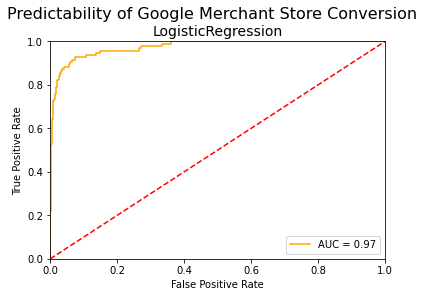

3


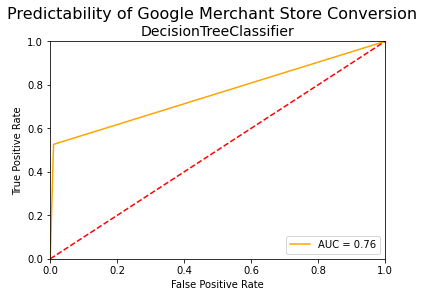

5


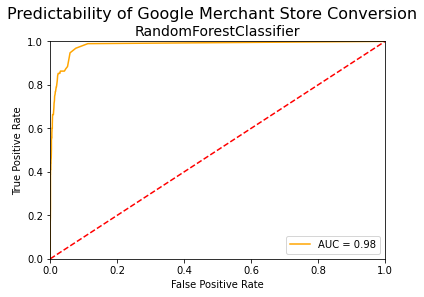

7


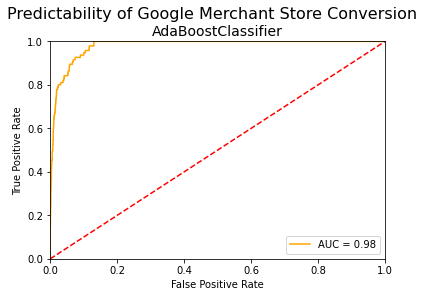

9


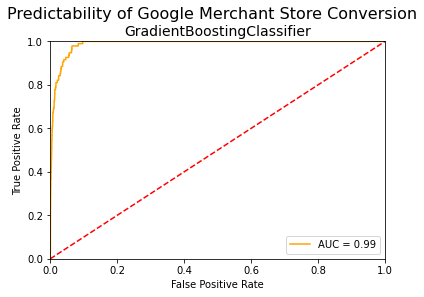

11


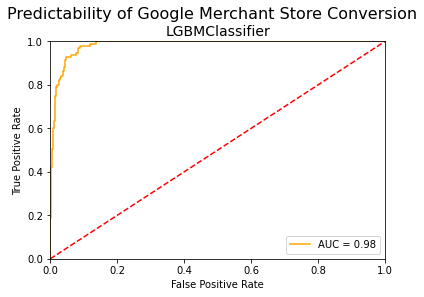

13


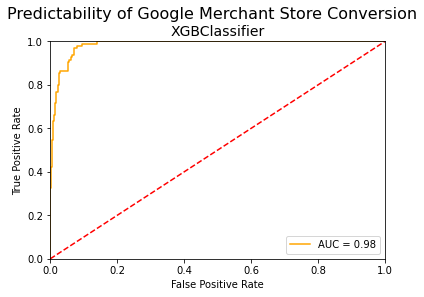

15


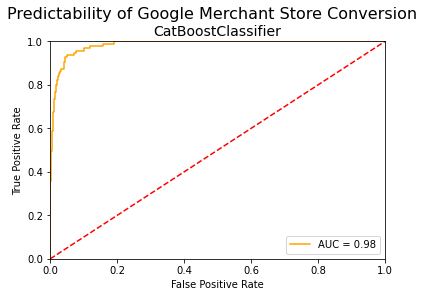

In [52]:
def plot_auc(labels, i):
## Compute the false positive rate, true positive rate
## and threshold along with the AUC
    j = 2*i + 1
    print(j)
    fpr, tpr, threshold = sklm.roc_curve(labels, proba_model[:,j])
    auc = sklm.auc(fpr, tpr)

## Plot the result
    plt.suptitle('Predictability of Google Merchant Store Conversion', y=1, fontsize=16)
    plt.title(algorithm[i], fontsize=14)
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

for i in range(0,8):   
    img=plot_auc(y_test, i)

Evaluate the model with the likehood to take the decision. The first column is the probability of a score of 0 (converted) and the second column is the probability of a score of 1. Notice that converted is very few cases here. 

### Features Importance

#### Predictors: identify number of total features, 

Rememner to count features included in the analysis as categorical variables that are treated as "dummy variables" or " individual type categorical efffect" plus the numerical variables. It is also need to notice their order in the estimation.

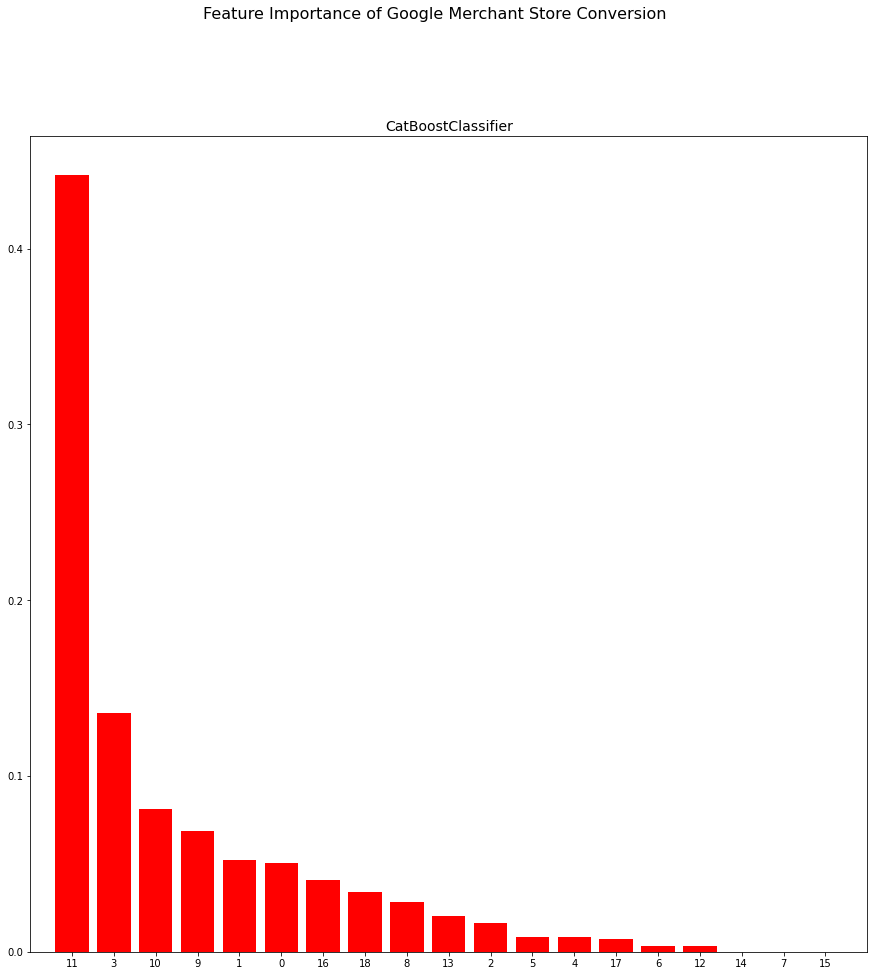

(19,)


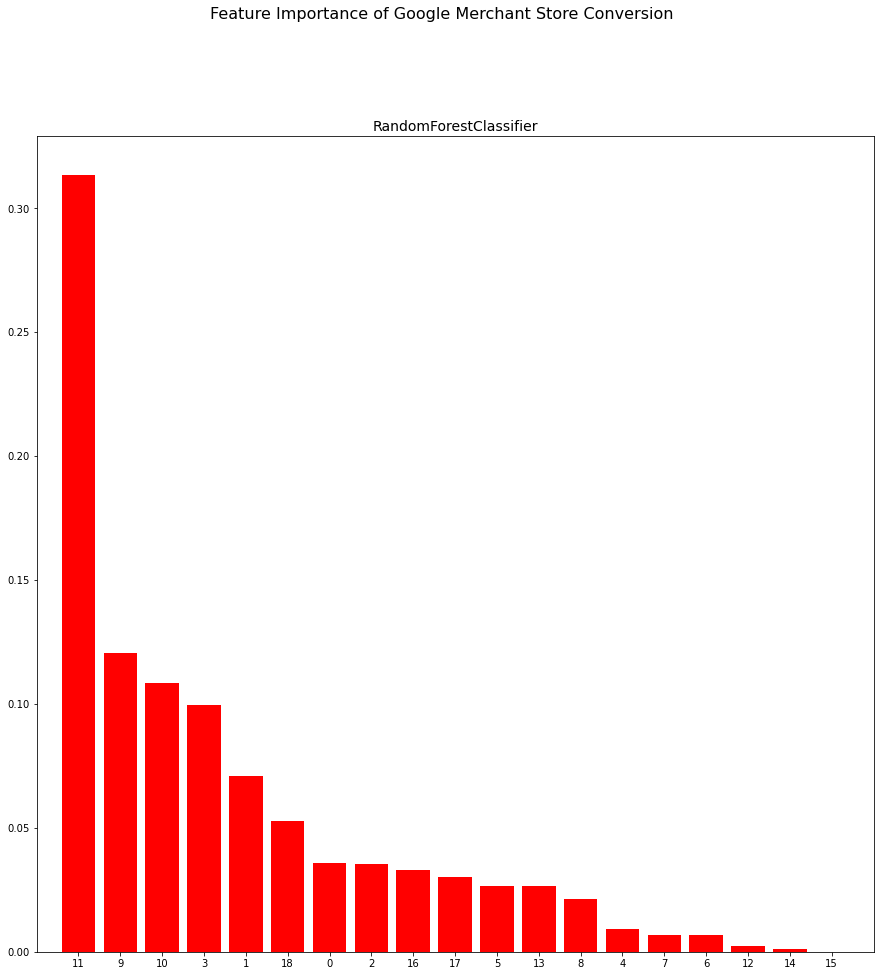

(19,)


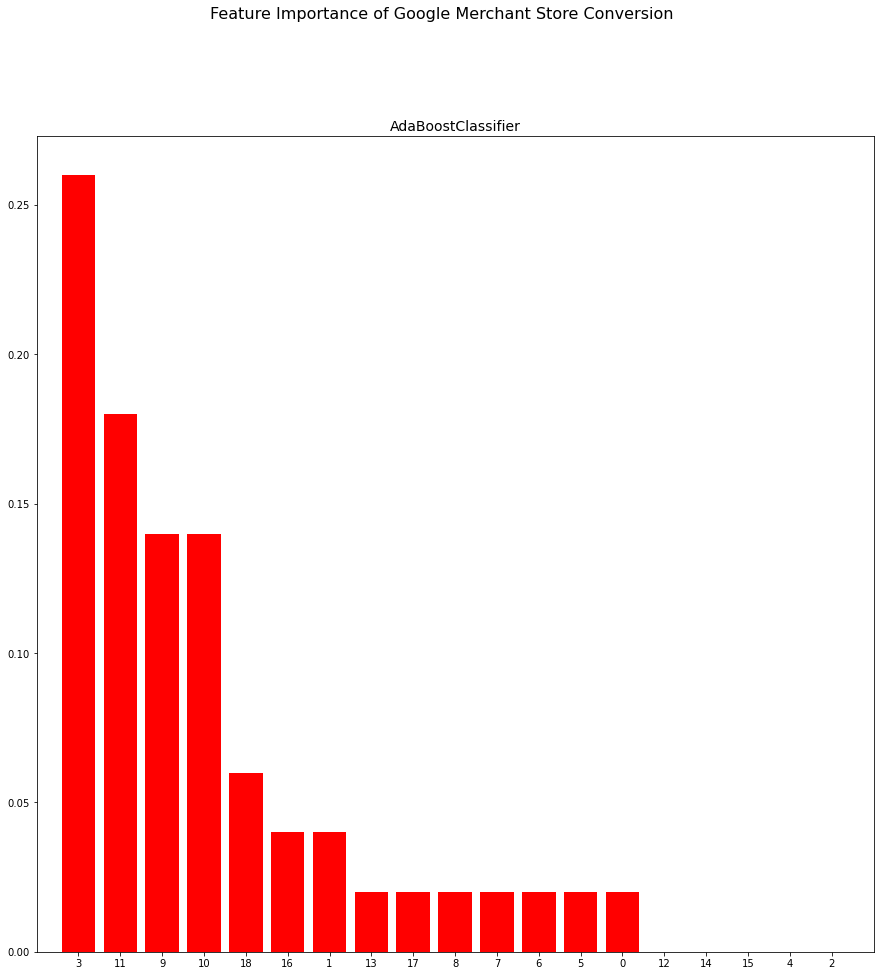

(19,)


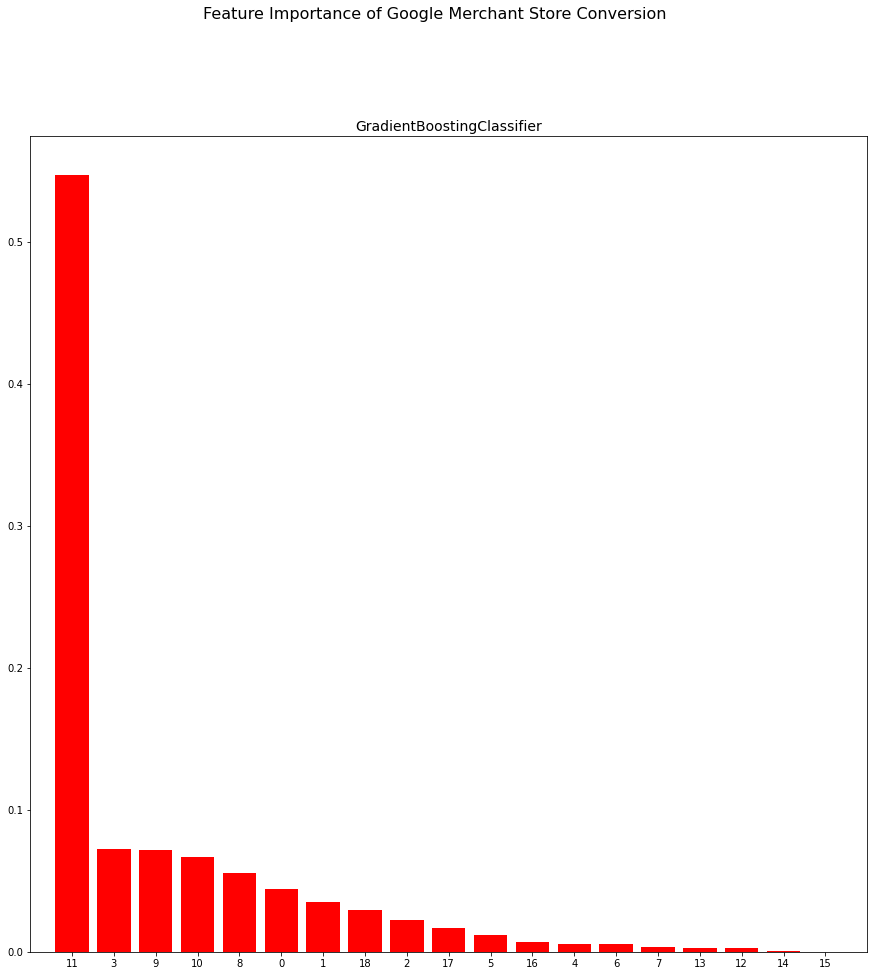

(19,)


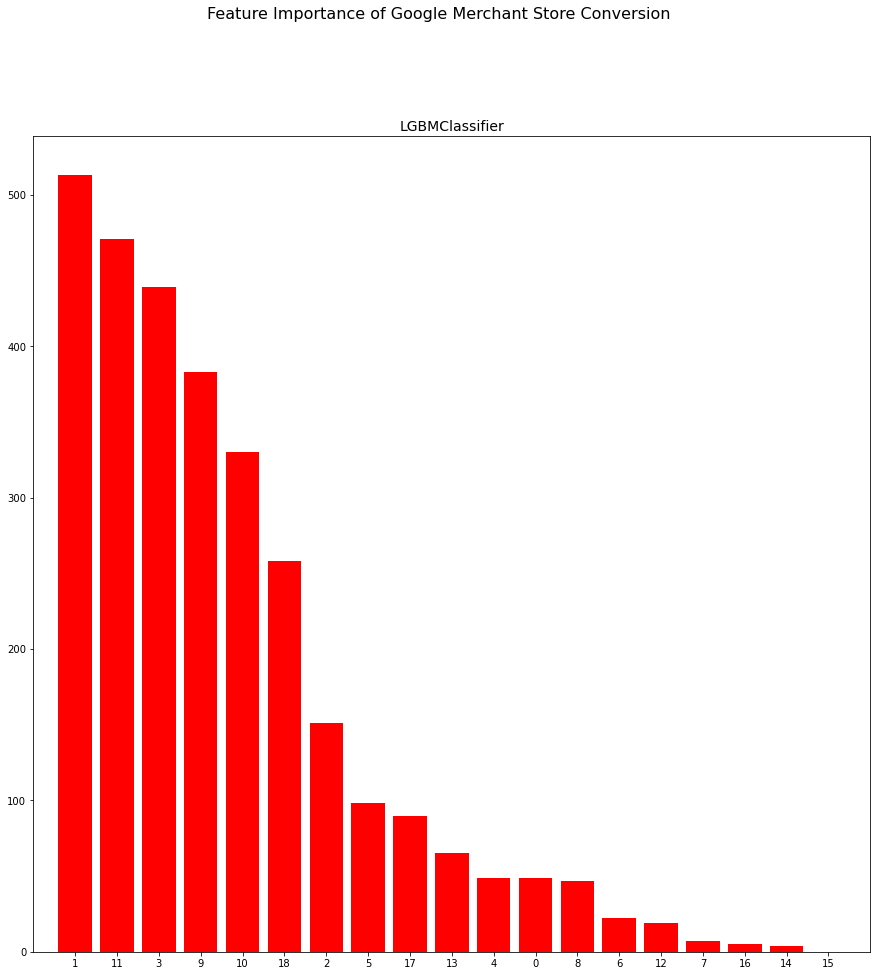

(19,)
[15:52:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Fenix\anaconda3\envs\econ7970\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



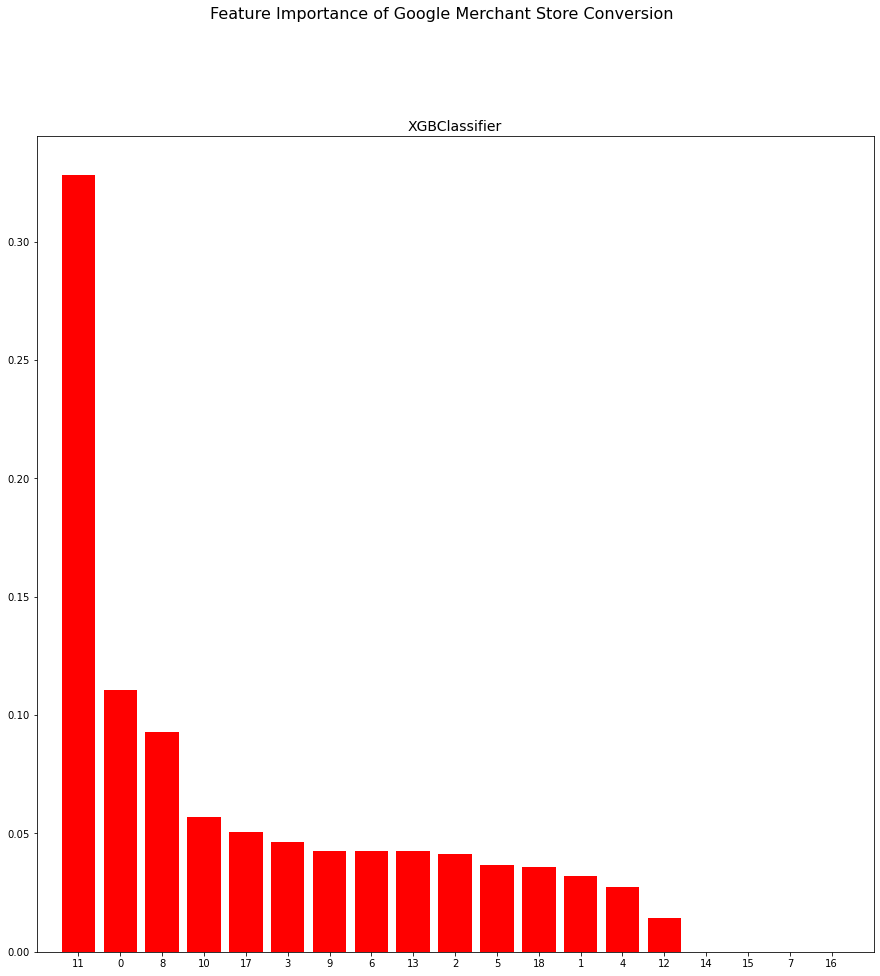

(19,)
Learning rate set to 0.028959
0:	learn: 0.6186376	total: 16.6ms	remaining: 16.6s
1:	learn: 0.5582290	total: 37.9ms	remaining: 18.9s
2:	learn: 0.4924128	total: 57.7ms	remaining: 19.2s
3:	learn: 0.4539083	total: 78.3ms	remaining: 19.5s
4:	learn: 0.4077024	total: 97.4ms	remaining: 19.4s
5:	learn: 0.3622243	total: 120ms	remaining: 19.8s
6:	learn: 0.3284344	total: 137ms	remaining: 19.5s
7:	learn: 0.2858372	total: 157ms	remaining: 19.5s
8:	learn: 0.2562329	total: 176ms	remaining: 19.4s
9:	learn: 0.2327598	total: 196ms	remaining: 19.4s
10:	learn: 0.2100447	total: 216ms	remaining: 19.4s
11:	learn: 0.1976388	total: 236ms	remaining: 19.4s
12:	learn: 0.1811092	total: 257ms	remaining: 19.5s
13:	learn: 0.1678126	total: 277ms	remaining: 19.5s
14:	learn: 0.1550474	total: 296ms	remaining: 19.5s
15:	learn: 0.1409030	total: 312ms	remaining: 19.2s
16:	learn: 0.1321573	total: 331ms	remaining: 19.1s
17:	learn: 0.1194767	total: 351ms	remaining: 19.2s
18:	learn: 0.1094999	total: 371ms	remaining: 19.2s


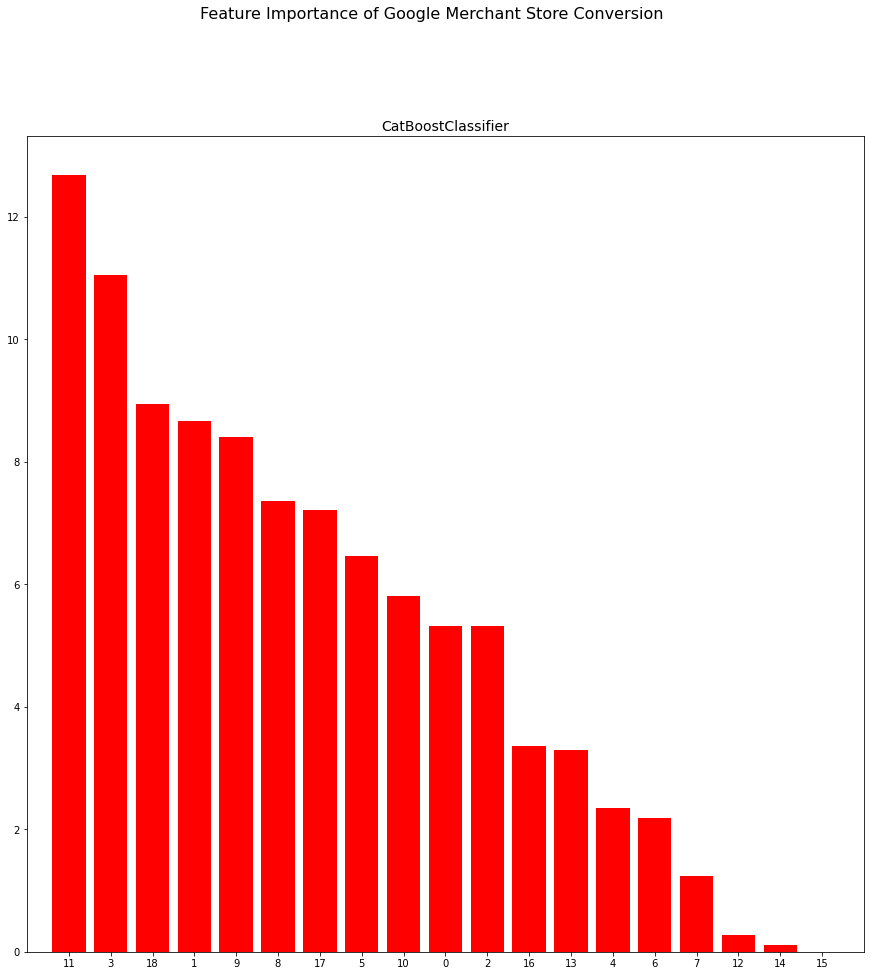

In [53]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
temp = clf.feature_importances_
importance = temp
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
# X_test is the train data used to test the model 
plt.figure(figsize=(15,15))
plt.suptitle('Feature Importance of Google Merchant Store Conversion', y=1, fontsize=16)
plt.title(algorithm[i], fontsize=14)
#plt.title("Feature importances", algorithm[i])
plt.bar(range(X_test.shape[1]), importances[indices],
          color="r", align="center")
plt.xticks(range(X_test.shape[1]), indices)
plt.xlim([-1, X_test.shape[1]])
plt.show()

for i in range(2, 8):   
    print(temp.shape)
    if i == 1:
         clf = DecisionTreeClassifier()
    if i == 2:
         clf = RandomForestClassifier()
    if i == 3:
         clf = AdaBoostClassifier() 
    if i == 4:
         clf = GradientBoostingClassifier()
    if i == 5:
         clf = LGBMClassifier()
    if i == 6:
         clf = XGBClassifier() 
    if i == 7:
         clf = CatBoostClassifier()
    clf.fit(X_train, y_train)
    temp = clf.feature_importances_
    importance = np.concatenate([importance, temp], axis = 0)
    importances = temp
    tempindex = np.argsort(importances)[::-1]
# X_test is the train data used to test the model 
    plt.figure(figsize=(15,15))
    plt.suptitle('Feature Importance of Google Merchant Store Conversion', y=1, fontsize=16)
    plt.title(algorithm[i], fontsize=14)
    plt.bar(range(X_test.shape[1]), importances[tempindex],color="r", align="center")
    plt.xticks(range(X_test.shape[1]), tempindex)
    plt.xlim([-1, X_test.shape[1]])
    plt.show()
    indices = np.concatenate([indices, tempindex], axis = 0)

### Models Selection

In [52]:

# Selected models for comparison
models = [('Logisitc Regression',LogisticRegression(solver = 'lbfgs', multi_class = 'ovr',max_iter=5000)),
('Decision Tree',DecisionTreeClassifier(criterion = 'entropy',max_depth = 5)),
('Random Forest',RandomForestClassifier(max_depth = 5))]

In [53]:
result=[]
for name, i in models:
    model_fitting = i.fit(X_train,np.ravel(y_train))
    ypred=model_fitting.predict(X_test)
    accuracy = accuracy_score(y_test, ypred)
    # Print results
    print("Selected model: " + name)
    print(classification_report(y_test,ypred))
    print("Accuracy: " + str(round(accuracy,4)))
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test,ypred))
    print('\n')
    result.append(model_fitting)

Selected model: Logisitc Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4905
           1       0.73      0.52      0.60        95

    accuracy                           0.99      5000
   macro avg       0.86      0.76      0.80      5000
weighted avg       0.99      0.99      0.99      5000

Accuracy: 0.9872
Confusion Matrix: 
[[4887   18]
 [  46   49]]


Selected model: Decision Tree
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4905
           1       0.63      0.55      0.58        95

    accuracy                           0.99      5000
   macro avg       0.81      0.77      0.79      5000
weighted avg       0.98      0.99      0.98      5000

Accuracy: 0.9852
Confusion Matrix: 
[[4874   31]
 [  43   52]]


Selected model: Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4905
           

### Q4: Based on the findings, suggest attracting more potential purchasers to the GStore based on decision model taught in the course


### Answer:

- Based on the findings from the session of "feature important", three models have their preference on important features for their prediction algorithm as below. However, both share the same idea that "totals.sessionQualityDim" is 1 of the Top 3 most important features to influence to the purchases. Based on the definition by Google on this feature, it estimates "how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting. A value of 0 indicates that Session Quality is not calculated for the selected time range." It imply that the user experience on the online shopping platform with a streamline platform with smooth and user-friendly transaction process is crucial to win the sales. I would suggest GStore to develop a AB test culture to schedule relevant A/B or multivariance tests on most of the tiny changes which would attract customers to visit the website and feel convenience on their purchasing experience. It can ensure the business always catch up the trend and demographical change of customers coming from different regions, different culture, also to win the loyalty from the customers to come back regularity to update themselves sometimes even they may not have intention to buy anything.


**Logistic Regression**
- visitStartTime
- month
- session Quality Dimension


**Decision Tree Classifier**
- session Quality Dimension
- totals.hits
- visit.start.time


**Random Forest Classifier**
- session Quality Dimension
- totals.page.views
- totals.hits

**(Please find detailed analysis and coding below)**

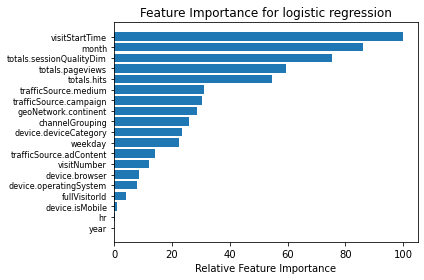

In [54]:
# Feature Importance for logistic regression 
feature_importance = abs(result[0].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
featax.set_title('Feature Importance for logistic regression')
plt.tight_layout()   
plt.show()

<AxesSubplot:title={'center':'Feature Importance For Decision Tree'}, xlabel='Field_Name'>

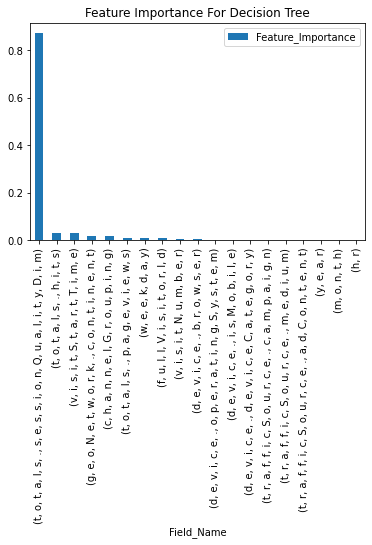

In [55]:
# Feature Importance For decision tree
feature_importance=pd.DataFrame({'Field_Name':train[train.columns[~train.columns.isin(['Potential_Purchase','totals.transactions'])]],'Feature_Importance':list(result[1].feature_importances_)})
feature_importance.sort_values(by=['Feature_Importance'],ascending=False,inplace=True)
feature_importance.plot(kind='bar',x='Field_Name',title='Feature Importance For Decision Tree')

<AxesSubplot:title={'center':'Feature Importance For Random Forest'}, xlabel='Field_Name'>

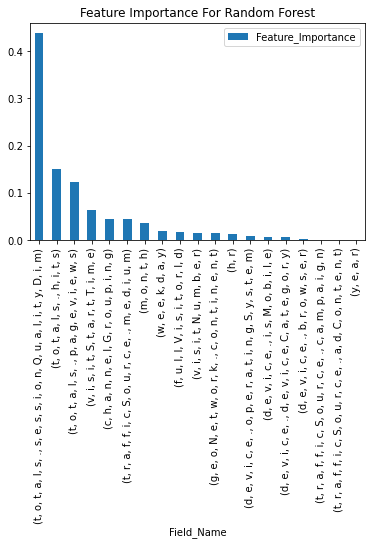

In [56]:
# Feature Importance For random forest
feature_importance=pd.DataFrame({'Field_Name':train[train.columns[~train.columns.isin(['Potential_Purchase','totals.transactions'])]],'Feature_Importance':list(result[2].feature_importances_)})
feature_importance.sort_values(by=['Feature_Importance'],ascending=False,inplace=True)
feature_importance.plot(kind='bar',x='Field_Name',title='Feature Importance For Random Forest')

THE END